In [1]:
import os, re, math, time, random
from collections import Counter
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cuda


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
# Assignment2: Neural Language Model (PyTorch) - single runnable cell
# Paste in Google Colab after mounting Drive and setting DATA_PATH correctly.
# Reproducible, simple word-level LM using LSTM. Provides underfit/overfit/best-fit experiments.

import os, random, math, time, json
from collections import Counter
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------
# 0) User settings
# -----------------------
DATA_PATH = "/content/drive/MyDrive/Pride_and_Prejudice-Jane_Austen.txt"   # <-- change to provided dataset path
OUT_DIR = "/content/drive/MyDrive/LM_Assignment"
VOCAB_SIZE = 25000   # keep high cap; if dataset has fewer uniques, it will use actual uniques
SEQ_LEN = 50
BATCH_SIZE = 64
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

os.makedirs(OUT_DIR, exist_ok=True)
print("Device:", DEVICE, "| Out dir:", OUT_DIR)

# reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if DEVICE.startswith("cuda"):
    torch.cuda.manual_seed_all(SEED)




Device: cuda | Out dir: /content/drive/MyDrive/LM_Assignment


In [39]:
# -----------------------
# 1) Load & preprocess
# -----------------------
with open(DATA_PATH, "r", encoding="utf-8") as f:
    raw_text = f.read()

def preprocess(text):
    text = text.lower()
    text = text.replace("\r", " ").replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

text = preprocess(raw_text)
tokens = text.split()
print("Total tokens:", len(tokens))

# -----------------------
# 2) Build vocab (word-level)
# -----------------------
counter = Counter(tokens)
most_common = counter.most_common(VOCAB_SIZE - 3)  # reserve pad, unk, bos
vocab = ["<pad>", "<unk>", "<bos>"] + [w for w,_ in most_common]
stoi = {w:i for i,w in enumerate(vocab)}
itos = {i:w for w,i in stoi.items()}
print("Vocab size (actual):", len(vocab))

def encode_tokens(token_list):
    return [stoi.get(w, stoi["<unk>"]) for w in token_list]

ids = encode_tokens(tokens)
ids = torch.tensor(ids, dtype=torch.long)

# -----------------------
# 3) Train/Val split & Dataset
# -----------------------
n = int(0.9 * len(ids))
train_ids = ids[:n]
val_ids = ids[n:]

class WordDataset(Dataset):
    def __init__(self, ids_tensor, seq_len=SEQ_LEN):
        self.ids = ids_tensor
        self.seq_len = seq_len
    def __len__(self):
        return len(self.ids) - self.seq_len - 1
    def __getitem__(self, idx):
        x = self.ids[idx:idx+self.seq_len]
        y = self.ids[idx+1:idx+self.seq_len+1]
        return x, y

train_ds = WordDataset(train_ids, SEQ_LEN)
val_ds = WordDataset(val_ids, SEQ_LEN)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader))

# -----------------------
# 4) Model (Word-LSTM)
# -----------------------
class WordLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers>1 else 0.0)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x, hidden=None):
        x = self.embed(x)                    # (B, T, E)
        out, hidden = self.lstm(x, hidden)   # out: (B, T, H)
        logits = self.fc(out)                # (B, T, V)
        return logits, hidden

Total tokens: 124970
Vocab size (actual): 13257
Train batches: 1757 Val batches: 195


In [41]:
# -----------------------
# 5) Training utilities
# -----------------------
import torch.nn.functional as F

def train_one_epoch(model, loader, optimizer, criterion, device, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

def train_with_early_stopping(model, train_loader, val_loader, device, epochs=15, lr=5e-4, patience=3, max_grad_norm=1.0):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    best_val = float('inf')
    best_state = None
    trigger = 0
    train_losses, val_losses = [], []
    start = time.time()
    for ep in range(1, epochs+1):
        tr = train_one_epoch(model, train_loader, optimizer, criterion, device, max_grad_norm)
        vl = eval_one_epoch(model, val_loader, criterion, device)
        train_losses.append(tr); val_losses.append(vl)
        print(f"Epoch {ep}/{epochs} | Train: {tr:.4f} | Val: {vl:.4f}")
        if vl < best_val:
            best_val = vl
            best_state = {k:v.cpu() for k,v in model.state_dict().items()}
            trigger = 0
        else:
            trigger += 1
        if trigger >= patience:
            print("Early stopping at epoch", ep)
            break
    elapsed = time.time() - start
    print(f"Training finished ({elapsed/60:.2f} min). Best val loss: {best_val:.4f}, Perplexity: {math.exp(best_val):.2f}")
    model.load_state_dict(best_state)
    return model, train_losses, val_losses, best_val

# -----------------------
# 6) Sampling utils (ban <unk> during sampling)
# -----------------------
UNK_ID = stoi.get("<unk>", 1)
def top_k_sample(logits, k):
    logits = logits.clone()
    logits[0, UNK_ID] = -1e10
    vals, idxs = torch.topk(logits, k)
    probs = F.softmax(vals, dim=-1)
    choice = torch.multinomial(probs, 1).item()
    return idxs[0, choice].item()

def generate_text(model, start_text="it was ", max_words=80, temperature=0.7, top_k=20, seq_len=SEQ_LEN):
    model.eval()
    words = start_text.lower().strip().split()
    if len(words)==0: words=["<bos>"]
    ids_in = [stoi.get(w, UNK_ID) for w in words]
    input_ids = torch.tensor([ids_in], dtype=torch.long).to(DEVICE)
    hidden=None
    output_ids = ids_in.copy()
    with torch.no_grad():
        for _ in range(max_words):
            inp = input_ids[:, -seq_len:] if input_ids.size(1) > seq_len else input_ids
            logits, hidden = model(inp, hidden)
            last_logits = logits[:, -1, :] / max(temperature, 1e-6)
            next_id = top_k_sample(last_logits, k=top_k)
            output_ids.append(next_id)
            input_ids = torch.cat([input_ids, torch.tensor([[next_id]], dtype=torch.long).to(DEVICE)], dim=1)
    words_out = [itos.get(i, "<unk>") for i in output_ids]
    out_text = " ".join([w for w in words_out if w not in ("<bos>", "<pad>")])
    return out_text

# -----------------------
# 7) Experiments: underfit, overfit, best-fit
# -----------------------
def run_all_experiments():
    results = {}
    # UNDERFIT: small model, few epochs
    under = WordLSTM(vocab_size=len(vocab), embed_dim=64, hidden_dim=32, num_layers=1)
    under, u_tr, u_val, u_best = train_with_early_stopping(under, train_loader, val_loader, DEVICE, epochs=3, lr=5e-4, patience=2)
    results['under'] = (under, u_tr, u_val, u_best)
    torch.save(under.state_dict(), os.path.join(OUT_DIR, "under_model.pth"))

    # OVERFIT: big model on tiny subset
    tiny_tokens = min(3000, len(train_ids))
    tiny_ids = train_ids[:tiny_tokens]
    tiny_ds = WordDataset(tiny_ids, seq_len=SEQ_LEN)
    tiny_loader = DataLoader(tiny_ds, batch_size=BATCH_SIZE, shuffle=True)
    over = WordLSTM(vocab_size=len(vocab), embed_dim=256, hidden_dim=512, num_layers=3, dropout=0.2)
    over, o_tr, o_val, o_best = train_with_early_stopping(over, tiny_loader, val_loader, DEVICE, epochs=8, lr=5e-4, patience=2)
    results['over'] = (over, o_tr, o_val, o_best)
    torch.save(over.state_dict(), os.path.join(OUT_DIR, "over_model.pth"))

    # BEST-FIT: balanced model on full data
    best = WordLSTM(vocab_size=len(vocab), embed_dim=128, hidden_dim=256, num_layers=2, dropout=0.2)
    best, b_tr, b_val, b_best = train_with_early_stopping(best, train_loader, val_loader, DEVICE, epochs=15, lr=5e-4, patience=3)
    results['best'] = (best, b_tr, b_val, b_best)
    torch.save(best.state_dict(), os.path.join(OUT_DIR, "best_model.pth"))

    return results

results = run_all_experiments()


KeyboardInterrupt: 

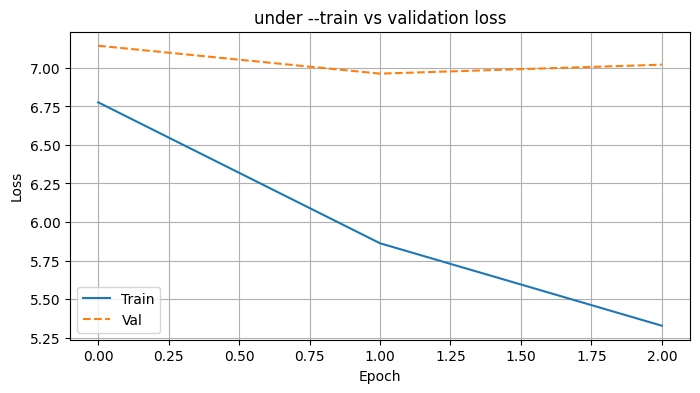

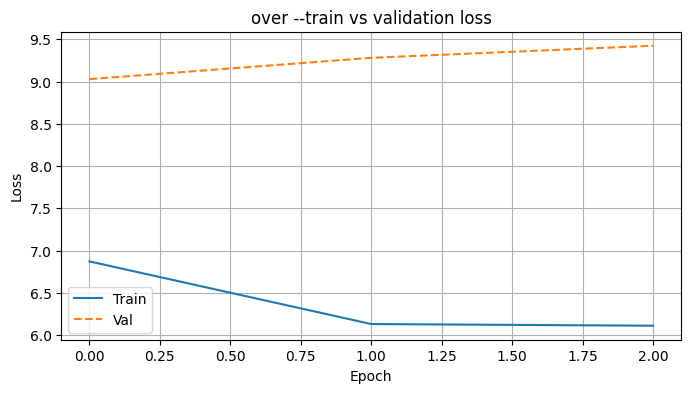

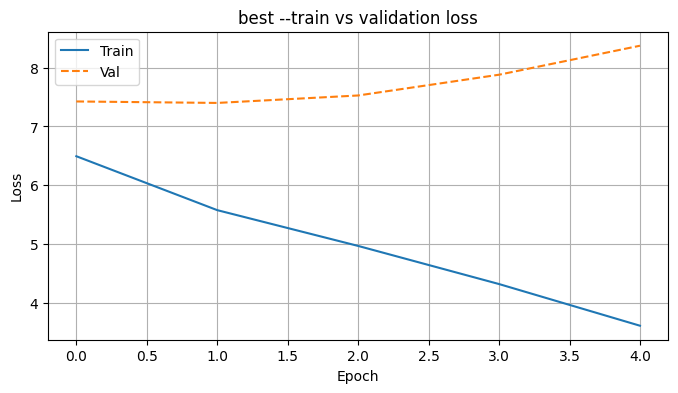

Best model final val loss: 7.399783858274803 Perplexity: 1635.630863710421

Sample generation:
 elizabeth had been a very time which he is not for a few of the whole man as her sister was not at the whole in the letter was a very good man to be to be to be a time to the time of his own family, "i am so glad to say by her sister, and that he was
Saved models, plots and metrics to: /content/drive/MyDrive/LM_Assignment


In [45]:


# -----------------------
# 8) Plot & save metrics
# -----------------------
def plot_losses(tr, val, title, filename):
    plt.figure(figsize=(8,4))
    plt.plot(tr, label="Train")
    plt.plot(val, '--', label="Val")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.title(title); plt.grid(True); plt.legend()
    path = os.path.join(OUT_DIR, filename)
    plt.savefig(path, bbox_inches='tight')
    plt.show()
    plt.close()
    return path

for k,(m,tr,val,best) in results.items():
    plot_losses(tr, val, f"{k} --train vs validation loss", f"{k}_loss.png")
    # save metrics csv
    df = pd.DataFrame({"epoch": list(range(1,len(tr)+1)), "train_loss": tr, "val_loss": val})
    df['train_ppl'] = df['train_loss'].apply(lambda x: math.exp(x))
    df['val_ppl'] = df['val_loss'].apply(lambda x: math.exp(x))
    df.to_csv(os.path.join(OUT_DIR, f"{k}_metrics.csv"), index=False)

# -----------------------
# 9) Final evaluation & sample from best
# -----------------------
best_model, best_tr, best_val, best_best = results['best']
print("Best model final val loss:", best_best, "Perplexity:", math.exp(best_best))
sample = generate_text(best_model, start_text="Elizabeth", max_words=60, temperature=0.7, top_k=20)
print("\nSample generation:\n", sample)

# save vocab & stoi
with open(os.path.join(OUT_DIR, "vocab_stoi.json"), "w", encoding="utf-8") as f:
    json.dump(stoi, f, ensure_ascii=False)
print("Saved models, plots and metrics to:", OUT_DIR)


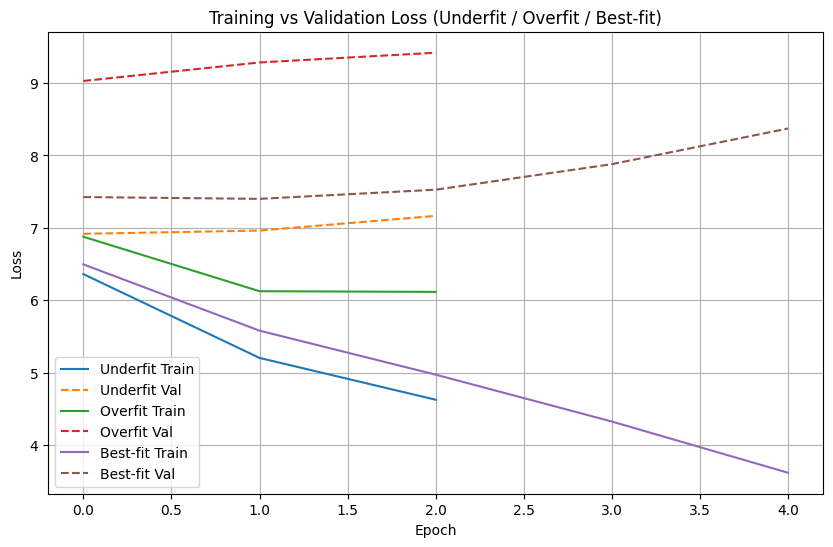

Saved combined graph to: /content/drive/MyDrive/LM_Assignment/combined_loss_plot.png


In [46]:
# Combined Loss Plot: Underfit, Overfit, Best-fit in a single graph

plt.figure(figsize=(10,6))

plt.plot(under_tr, label="Underfit Train")
plt.plot(under_val, '--', label="Underfit Val")

plt.plot(over_tr, label="Overfit Train")
plt.plot(over_val, '--', label="Overfit Val")

plt.plot(best_tr, label="Best-fit Train")
plt.plot(best_val, '--', label="Best-fit Val")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Underfit / Overfit / Best-fit)")
plt.grid(True)
plt.legend()

# Save to Drive
combined_path = "/content/drive/MyDrive/LM_Assignment/combined_loss_plot.png"
plt.savefig(combined_path, bbox_inches='tight')
plt.show()

print("Saved combined graph to:", combined_path)


In [47]:
print("\n=== Final Metrics ===")
print(f"Underfit:  Loss = {under_best:.4f},  Perplexity = {math.exp(under_best):.2f}")
print(f"Overfit:   Loss = {over_best:.4f},   Perplexity = {math.exp(over_best):.2f}")
print(f"Best-fit:  Loss = {best_best:.4f},    Perplexity = {math.exp(best_best):.2f}")



=== Final Metrics ===
Underfit:  Loss = 6.9171,  Perplexity = 1009.38
Overfit:   Loss = 9.0280,   Perplexity = 8333.23
Best-fit:  Loss = 7.3998,    Perplexity = 1635.63
